In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
df = pd.read_csv("car_fuel_efficiency.csv")

In [27]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [28]:
model_columns = ['engine_displacement',
'horsepower',
'vehicle_weight',
'model_year',
'fuel_efficiency_mpg'
]

df2 = df[model_columns].copy()

In [29]:
df2.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

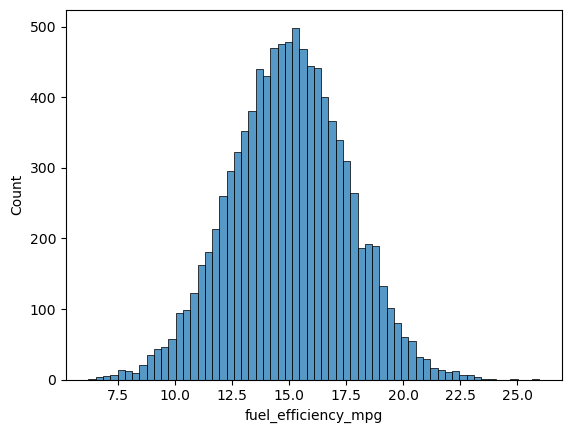

In [30]:
sns.histplot(df2["fuel_efficiency_mpg"])

In [31]:
df2.isnull().sum()

# horsepower has null values

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [32]:
df2['horsepower'].describe()

# 50% percentile -> 149

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [33]:
n = len(df2)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

n_train, n_val, n_test

(5824, 1940, 1940)

In [34]:
np.random.seed(42)

idx = np.arange(n)
np.random.shuffle(idx)
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270])

In [35]:
df_train = df2.iloc[idx[:n_train]]
df_val = df2.iloc[idx[n_train:n_train+n_val]]
df_test = df2.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["fuel_efficiency_mpg"]
y_val = df_val["fuel_efficiency_mpg"]
y_test = df_test["fuel_efficiency_mpg"]

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [36]:
df_train_0 = df_train.fillna(0)
df_val_0 = df_val.fillna(0)
df_test_0 = df_test.fillna(0)

mean = df2['fuel_efficiency_mpg'].mean()

df_train_mean = df_train.fillna(mean)
df_val_mean = df_val.fillna(mean)
df_test_mean = df_test.fillna(mean)

In [37]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    # print(XTX_inv.dot(XTX).round())
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [38]:
w0, w = train_linear_regression(df_train_0, y_train)
w0m, wm = train_linear_regression(df_train_mean, y_train)

y_pred_0 = w0 + df_val_0.dot(w)
y_pred_mean = w0m + df_val_mean.dot(wm)

rmse_0 = rmse(y_val, y_pred_0)
rmse_mean = rmse(y_val, y_pred_mean)

rmse_0, rmse_mean # mean is better

(np.float64(0.5173782638835324), np.float64(0.5128869000611066))

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

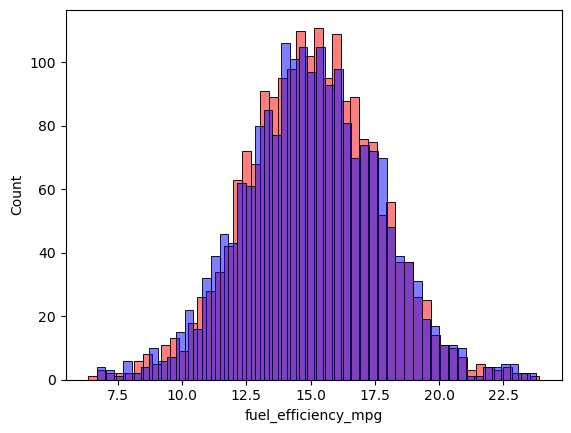

In [39]:
sns.histplot(y_pred_0, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

In [40]:
for r in [0, 0.01, 0.1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(df_train_0, y_train, r=r)
    y_pred = w0 + df_val_0.dot(w)
    rms = rmse(y_val, y_pred)
    print(r, rms.round(3))

# r=0, best RMSE

0 0.517
0.01 0.517
0.1 0.519
5 0.523
10 0.523
100 0.523


In [41]:
n = len(df2)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

rmses = np.zeros(10)

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_train = df2.iloc[idx[:n_train]]
    df_val = df2.iloc[idx[n_train:n_train+n_val]]
    df_test = df2.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True).fillna(0)
    df_val = df_val.reset_index(drop=True).fillna(0)
    df_test = df_test.reset_index(drop=True).fillna(0)

    y_train = df_train["fuel_efficiency_mpg"]
    y_val = df_val["fuel_efficiency_mpg"]
    y_test = df_test["fuel_efficiency_mpg"]

    del df_train["fuel_efficiency_mpg"]
    del df_val["fuel_efficiency_mpg"]
    del df_test["fuel_efficiency_mpg"]

    w0, w = train_linear_regression(df_train, y_train)
    y_pred = w0 + df_val.dot(w)

    rmses[seed] = rmse(y_val, y_pred)

# print(rmses)
print(np.std(rmses)) # 0.006, model is stable
    

0.006989446426375709


In [42]:
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_train_val = df2.iloc[idx[:n_train+n_val]]
df_test = df2.iloc[idx[n_train+n_val:]]

df_train_val = df_train_val.reset_index(drop=True).fillna(0)
df_test = df_test.reset_index(drop=True).fillna(0)

y_train_val = df_train_val["fuel_efficiency_mpg"]
y_test = df_test["fuel_efficiency_mpg"]

del df_train_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

w0, w = train_linear_regression_reg(df_train_val, y_train_val, r=0.001)
y_pred = w0 + df_test.dot(w)

rmse(y_test, y_pred) # 0.515

np.float64(0.5156261299185867)